# Spanish non-peninsular emission factors

The [current approach](https://colab.research.google.com/drive/1buA-yHQCF711F53IX7_GAxYMJ9p4qJoT#scrollTo=wIpaSc_Hgy7i) used to calculate EU emission factors is not able to calculate the emission factors of these zones, as their production is not reported to ENTSO-E. To be able to accurately measure the intensity of their electricity it is necessary to follow an alternative methodology.

This new method is similar, in that it uses annual electricity production and emissions data to compute the emissions per kWh of electricity. Our sources in this case will be:

- REE's [demanda.ree.es](https://demanda.ree.es) for annual electricity production. The data available is an aggregate of the production of all generators in each island or system, divided by fuel. Note that REE's categories need to be mapped to EM categories.

- Emissions data can be obtained from [EU-ETS registry](https://climate.ec.europa.eu/eu-action/eu-emissions-trading-system-eu-ets/union-registry_en), as in the general case.

For each given fuel, zone and year, we will obtain the corresponding emission factor by dividing total emissions by total production in that year.

There are some edge cases to consider. Sometimes, a power plant produces electricity from two different fuels. In this case, it is impossible to compute the intensity values as we can not map the emissions to each fuel.

### Electricity production data

The production values per system and fuel can be downloaded from REE's page. In this case, to simplify data adquisition, an ad-hoc script that calls the ES parser from the EM repository has been employed. This parser contains most of the logic needed to obtain the data.

Following are data already computed and the Python script used to obtain it.


Note that some data points have being removed manually due to incorrect reporting by REE

In [1]:
PRODUCTION_DATA = {
    "ES-IB-ME" : {
        2017 : 422875.775077,
        2018 : 478983.916458,
        2019 : 479678.874977,
        2020 : 349145.074985,
        2021 : 373395.01671,
        2022 : 412357.025037,
    },
    "ES-IB-IZ (gas)" : {
        2017 : 927207.716905,
        2018 : 913244.699988,
        2019 : 428725.183395,
        2020 : 143425.099979,
        2021 : 255090.499969,
        2022 : 388904.975038,
    },
    "ES-CN-HI" : {
        2017 : 24724.475338,
        2018 : 19158.990104,
        2019 : 20460.299462,
        2020 : 28286.924295,
        2021 : 25819.624999,
        2022 : 25694.041414,
        2023 : 33741.707739,
    },
    "ES-CN-FVLZ" : {
        2017 : 1515563.175025,
        2018 : 1471065.374982,
        2019 : 1402101.716819,
        2020 : 1121512.375059,
        2021 : 1116423.975036,
        2022 : 1284931.516733,
        2023 : 1367014.774921,
    },
    "ES-CN-GC" : {
        2017 : 3203081.466642,
        2018 : 3016455.208299,
        2019 : 2894098.674984,
        2020 : 2677012.658181,
        2021 : 2551784.283387,
        2022 : 2531452.075076,
        2023 : 2599146.066643,
    },
    "ES-CN-IG" : {
        2017 : 75582.175187,
        2018 : 74514.983365,
        2019 : 75628.500038,
        2020 : 69852.200008,
        2021 : 69497.291734,
        2022 : 70435.266649,
        2023 : 64412.77498,
    },
    "ES-CN-LP" : {
        2017 : 244418.566669,
        2018 : 242687.241658,
        2019 : 244844.59181,
        2020 : 234406.808362,
        2021 : 233139.433166,
        2022 : 229736.54164,
        2023 : 242507.558288,
    },
    "ES-CN-TE" : {
        2017 : 3263387.95842,
        2018 : 3187850.249959,
        2019 : 2887694.933186,
        2020 : 2540683.641714,
        2021 : 2575534.291732,
        2022 : 2784201.391737,
        2023 : 2876485.308361,
    },
}

These scripts are provided as a means to check the correctness of the data above and to improve reproducibility.

They must be run inside the EM repository, as they use the already existing ES parser. The code works as a wrapper that queries all data and uses a database to buffer already downloaded production data, so as to minimize unnecessary requests.

In [ ]:
## year_calc.py

import ast
import calendar
from datetime import datetime, timedelta
from logging import getLogger

from electricitymap.contrib.lib.models.events import ProductionMix
from electricitymap.contrib.parsers.ES import fetch_production


def calc(zone, year, cur):
    total = ProductionMix()
    for single_date in (
        datetime.fromisoformat(f"{year}-01-01 00:00") + timedelta(n)
        for n in range(365 + calendar.isleap(year))
    ):
        res = cur.execute(
            f"SELECT value FROM elecData WHERE elecData.date == '{single_date}' AND elecData.zone == '{zone}'"
        ).fetchone()
        if res is not None:
            values = ast.literal_eval(res[0])
            for key in values:
                total.add_value(key, values[key])
            continue
        res = fetch_production(
            zone, target_datetime=single_date, logger=getLogger(__name__)
        )
        print(single_date)
        buffer = ProductionMix()
        for response in res:
            if response.get("datetime").day == single_date.day:
                for fuel in response.get("production"):
                    buffer.add_value(
                        fuel,
                        0
                        if response.get("production").get(fuel) is None
                        else response.get("production").get(fuel) / 12,
                    )
        cur.execute(
            f"""
                    INSERT INTO elecData(date, zone, value) VALUES
                        ('{single_date}', '{zone}', "{buffer.dict()}")
                    """
        )
        for key in response.get("production"):
            total.add_value(key, buffer.dict().get(key))
    print()
    print(year)
    print(zone)
    print(total)
    print()
    cur.execute(
        f"""
    INSERT INTO yearElecData(date, zone, value) VALUES
        ({year}, '{zone}', "{total.dict()}")
"""
    )


In [ ]:
import sqlite3

from year_calc import calc

con = sqlite3.connect("data.sql", isolation_level=None)

cur = con.cursor()

# Run once to init sql file:
#
# cur.execute("CREATE TABLE elecData(date, zone, value)")
# cur.execute("CREATE TABLE yearElecData(date, zone, value)")

# Change zones and dates as needed

INITIAL_YEAR = 2017
LAST_YEAR = 2023  # included

ZONES = [
    "ES-IB-IZ",
    "ES-IB-ME",
    "ES-CN-HI",
    "ES-CN-FVLZ",
    "ES-CN-GC",
    "ES-CN-IG",
    "ES-CN-LP",
    "ES-CN-TE",
]

for zone in ZONES:
    for delta in range(LAST_YEAR - INITIAL_YEAR + 1):
        calc(zone, INITIAL_YEAR + delta, cur)


### EU-ETS data

We can use a method similar to the one used in the general case.

All these power plants use oil for fuel, except the one in Ibiza. In systems with more than one fuel, one grouping per fuel would be needed. However this is not the case for any of these zones.


In [2]:
SYSTEM_PLANT_MAPPING = {
    "ES-IB-ME" : [
        "Maó"],
    "ES-IB-IZ (gas)" : [
        "Eivissa"],
    "ES-CN-HI":[
        "Llanos Blancos"],
    "ES-CN-LP" : [
        "Los Guinchos"],
    "ES-CN-IG":[
        "El Palmar"],
    "ES-CN-TE" : [
        "Granadilla",
        "Candelaria",
        "Guía de Isora",
        "Arona"],
    "ES-CN-GC" : [
        "Barranco de Tirajana",
        "Jinámar"],
    "ES-CN-FVLZ" : [
        "Las Salinas",
        "Punta Grande"]
}

NAME_ID_MAPPING = {
    "Maó" : "ES130701000793",
    "Eivissa" : "ES130701000781",
    "Llanos Blancos" : "ES043801001275",
    "Los Guinchos" : "ES043801000287",
    "El Palmar" : "ES043801001276",
    "Granadilla" : "ES043801000236",
    "Candelaria" : "ES043801000262",
    "Guía de Isora" : "ES043801001347",
    "Arona" : "ES043801000297",
    "Barranco de Tirajana" : "ES043501000258",
    "Jinámar" : "ES043501000276",
    "Las Salinas" : "ES043501000243",
    "Punta Grande" : "ES043501000250"
}


Latest ETS data can be dowloaded from the official webpage. We convert the xlsx to csv for easier handling.

In [3]:
!curl -L "https://climate.ec.europa.eu/document/download/ebb2c20e-8737-4a73-b6ba-a4b7e78ecc01_en?filename=verified_emissions_2023_en.xlsx" > verified_emissions_2023.xlsx

import pandas as pd
data_xls = pd.read_excel('verified_emissions_2023.xlsx', 'data', skiprows=21, index_col = None)
data_xls.to_csv('verified_emissions_2023.csv', encoding='utf-8')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5274k  100 5274k    0     0  7630k      0 --:--:-- --:--:-- --:--:-- 7632k


In [4]:
def get_eu_ets_emissions_data(year: int, id: str) -> pd.DataFrame:
    '''This function extracts emissions and allocation for the chosen year. '''
    csv_emissions = "verified_emissions_2023.csv"
    df_emissions = pd.read_csv(csv_emissions)
    df_emissions = df_emissions.loc[df_emissions["PERMIT_IDENTIFIER"] == id]
    df_emissions[f"VERIFIED_EMISSIONS_{str(year)}"] = df_emissions[f"VERIFIED_EMISSIONS_{str(year)}"].apply(lambda x: float(x))
    return df_emissions

This is an example command for the previous function. It obtains the emissions for "Llanos Blancos" plant in the year 2021.

In [ ]:
df_emissions = get_eu_ets_emissions_data(year= 2021, id ="ES043801001275")
print(df_emissions["VERIFIED_EMISSIONS_2021"].iloc[0])

18311.0


### Results - Calculating the emission factors

By combining both previous sections we can obtain the intensity values.

Each production data point is matched with the corresponding emissions data point and stored in a dictionary.

In [5]:
EMISSIONS_DATA = {}
for zone in PRODUCTION_DATA:
  EMISSIONS_DATA[zone] = {}
  for year in PRODUCTION_DATA.get(zone):
    total_emissions = 0
    for pp in SYSTEM_PLANT_MAPPING[zone]:
      total_emissions = total_emissions + get_eu_ets_emissions_data(year, NAME_ID_MAPPING.get(pp))[f"VERIFIED_EMISSIONS_{str(year)}"].iloc[0]
    EMISSIONS_DATA.get(zone)[year] = total_emissions * 1000 / PRODUCTION_DATA[zone][year]

print(EMISSIONS_DATA)


{'ES-IB-ME': {2017: 773.0922868316868, 2018: 814.3989528596306, 2019: 812.543600171445, 2020: 777.2843423658754, 2021: 781.3976805871657, 2022: 838.7585975259326}, 'ES-IB-IZ (gas)': {2017: 618.2886418521227, 2018: 590.3291856028115, 2019: 583.131128477851, 2020: 635.2165695777068, 2021: 581.127090260182, 2022: 570.6998219251719}, 'ES-CN-HI': {2017: 681.6727056730073, 2018: 697.8969104017864, 2019: 689.5793498137217, 2020: 693.3945803173438, 2021: 709.1892310871746, 2022: 717.0534095100062, 2023: 709.6558415246844}, 'ES-CN-FVLZ': {2017: 724.1888811278984, 2018: 722.0963922238994, 2019: 722.0053922312421, 2020: 709.958282857211, 2021: 701.9662937413443, 2022: 726.5904741552072, 2023: 699.2952947821974}, 'ES-CN-GC': {2017: 712.8844594745403, 2018: 704.6161315945918, 2019: 703.5160955634162, 2020: 688.4588290487601, 2021: 692.1556855329748, 2022: 688.2476730070797, 2023: 689.4991485856154}, 'ES-CN-IG': {2017: 683.9575584071235, 2018: 696.1016114829271, 2019: 692.6357123793258, 2020: 697.32

We can plot the results to check for patterns or errors, and to compare the different zones.

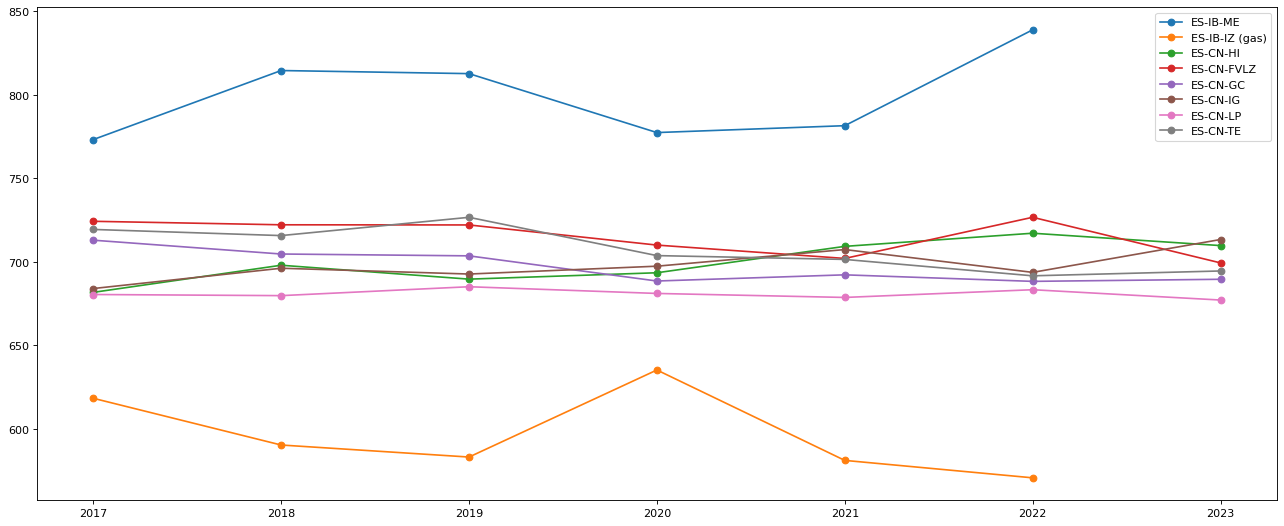

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8), dpi=80)

for zone in EMISSIONS_DATA:
  dates = list(EMISSIONS_DATA[zone].keys())
  prices = list(EMISSIONS_DATA[zone].values())
  plt.plot(dates, prices, '-o')
plt.gca().legend(EMISSIONS_DATA.keys())
plt.show()

We can appreciate several anomalies, namely in Menorca and Ibiza.

The change in the Menorca zone intensity can be explained by a higher proportion of production from "Gas turbine" instead of "Diesel engine". These "Gas turbines" produce more CO2 but less other pollutants per kWh. Note that despite the name they use oil as fuel.

The higher factor for 2020 for Ibiza could be explained by a lower use factor, and therefore less efficient production